<a href="https://colab.research.google.com/github/wep69/GeoModels-page/blob/master/pilar_indices_diferencas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Instalar e Importar as Bibliotecas Necessárias
#!pip install -q condacolab
#import condacolab
#condacolab.install()
!pip install "dask[distributed]" --upgrade
# Import the libraries
import xarray as xr
import numpy as np
import cupy as cp
import dask.array as da
from dask.distributed import Client
from tqdm.notebook import tqdm

# Initialize Dask client
client = Client()
print(client)




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.6 MB/s eta 0:00:00
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.1
    Uninstalling cloudpickle-2.2.1:
      Successfully uninstalled cloudpickle-2.2.1
  Attempting uninstall: dask
    Found existing installation: dask 2024.8.0
    Uninstalling dask-2024.8.0:
      Successfully uninstalled dask-2024.8.0
  Attempting uninstall: distributed
    Found existing installation: distributed 2024.8.0
    Uninstalling distributed-2024.8.0:
      Successfully uninstalled distributed-2024.8.0


INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:33297
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37259'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40937'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39511'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40709'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:38847', name: 2, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:38847
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:35210
INFO:distributed.scheduler:Regist

<Client: 'tcp://127.0.0.1:33297' processes=4 threads=12, memory=83.48 GiB>


In [2]:

# 2. Montar o Google Drive
#from google.colab import drive
#drive.mount('/content/drive')


# Define the chunk size (adjust as needed)
chunks = {'time': 1, 'y': 500, 'x': 500}

# Define the path to your dataset
dataset_path = '/content/drive/MyDrive/Vários/Pilar/Tercer articulo/Resultados/bosque_indices.nc'  # Update with your path

# Load the dataset with Dask and convert arrays to CuPy
ds = xr.open_dataset(dataset_path, chunks=chunks)

# Convert data variables to CuPy arrays
for var in ds.data_vars:
    ds[var].data = ds[var].data.map_blocks(cp.asarray, dtype=cp.float32)

# 4. Definir a lista de variáveis a serem processadas
# Define the list of variables to process
variables_to_process = ['NDVI', 'SAVI', 'GEMI', 'MSAVI', 'FI', 'NDMI', 'FCI2']
#variables_to_process = ['FI']
# Define the reference year and years to compare
reference_year = '1989'
other_years = ['1999', '2009', '2019', '2023']

# Initialize the results dictionary
results = {}

for var in tqdm(variables_to_process, desc='Processando variáveis'):
    if var in ds:
        # Get reference data and ensure it's a CuPy array
        ref_data = ds[var].sel(time=reference_year).squeeze('time').data

        # Initialize lists to store results for each year
        cohen_list = []
        perc_change_list = []
        drnorm_list = []

        for year in tqdm(other_years, desc=f'Processando {var}', leave=False):
            # Get current data
            curr_data = ds[var].sel(time=year).squeeze('time').data

            # 6a. Calculate the difference between the current year and the reference
            diff = curr_data - ref_data

            # 6b. Calculate the standard deviation over spatial dimensions
            std_ref = da.nanstd(ref_data, axis=(0, 1))
            std_curr = da.nanstd(curr_data, axis=(0, 1))
            pooled_std = da.sqrt((std_ref**2 + std_curr**2) / 2)

            # 6c. Calculate Cohen's d
            cohen_d = diff / pooled_std
            cohen_d = da.where(da.isfinite(cohen_d), cohen_d, np.nan)

            # 6d. Calculate the percentage change (100 indicates no change)
            perc_change = ((curr_data - ref_data) / da.fabs(ref_data)) * 100 + 100
            #perc_change = ((curr_data) / da.fabs(ref_data)) * 100 + 100
            perc_change = da.where(da.isfinite(perc_change), perc_change, np.nan)

            # 6e. Calculate the normalized relative difference
            drnorm = (curr_data - ref_data) / (curr_data + ref_data)
            drnorm = da.where(da.isfinite(drnorm), drnorm, np.nan)

            # Create DataArrays
            cohen_da = xr.DataArray(cohen_d, dims=['y', 'x'], coords={'y': ds['y'], 'x': ds['x']})
            cohen_da = cohen_da.expand_dims('time').assign_coords(time=[year])

            perc_change_da = xr.DataArray(perc_change, dims=['y', 'x'], coords={'y': ds['y'], 'x': ds['x']})
            perc_change_da = perc_change_da.expand_dims('time').assign_coords(time=[year])

            drnorm_da = xr.DataArray(drnorm, dims=['y', 'x'], coords={'y': ds['y'], 'x': ds['x']})
            drnorm_da = drnorm_da.expand_dims('time').assign_coords(time=[year])

            # Append to lists
            cohen_list.append(cohen_da)
            perc_change_list.append(perc_change_da)
            drnorm_list.append(drnorm_da)

        # Concatenate results along 'time' dimension
        cohen_da = xr.concat(cohen_list, dim='time')
        perc_change_da = xr.concat(perc_change_list, dim='time')
        drnorm_da = xr.concat(drnorm_list, dim='time')

        # Assign names
        cohen_da.name = f'{var}_cohen'
        perc_change_da.name = f'{var}_perc'
        drnorm_da.name = f'{var}_drnorm'
        # Add to results
        results[f'{var}_cohen'] = cohen_da
        results[f'{var}_perc'] = perc_change_da
        results[f'{var}_drnorm'] = drnorm_da

# Create the results Dataset
results_ds = xr.Dataset(results)

# Transpose dimensions to (time, y, x)
results_ds = results_ds.transpose('time', 'y', 'x')

# Compute the results
results_ds = results_ds.compute()

# Converter arrays do CuPy para arrays do NumPy
for var in results_ds.data_vars:
    data = results_ds[var].data
    if isinstance(data, cp.ndarray):
        # Converter o array do CuPy para um array do NumPy
        results_ds[var].data = cp.asnumpy(data)

# 9. Salvar o resultado no Google Drive
output_path = '/content/drive/MyDrive/Vários/Pilar/Tercer articulo/Resultados/bosque_bindices_diferencas.nc'

# Salvar o dataset
results_ds.to_netcdf(output_path)
print(f"Resultados salvos em: {output_path}")

INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


Processando variáveis:   0%|          | 0/7 [00:00<?, ?it/s]

Processando NDVI:   0%|          | 0/4 [00:00<?, ?it/s]

Processando SAVI:   0%|          | 0/4 [00:00<?, ?it/s]

Processando GEMI:   0%|          | 0/4 [00:00<?, ?it/s]

Processando MSAVI:   0%|          | 0/4 [00:00<?, ?it/s]

Processando FI:   0%|          | 0/4 [00:00<?, ?it/s]

Processando NDMI:   0%|          | 0/4 [00:00<?, ?it/s]

Processando FCI2:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:distributed.core:Event loop was unresponsive in Nanny for 3.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Resultados salvos em: /content/drive/MyDrive/Vários/Pilar/Tercer articulo/Resultados/bosque_bindices_diferencas.nc


In [3]:
fi=xr.open_dataset('/content/drive/MyDrive/Vários/Pilar/Tercer articulo/Resultados/bosque_indices_diferencas.nc')

INFO:distributed.core:Event loop was unresponsive in Nanny for 4.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 4.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

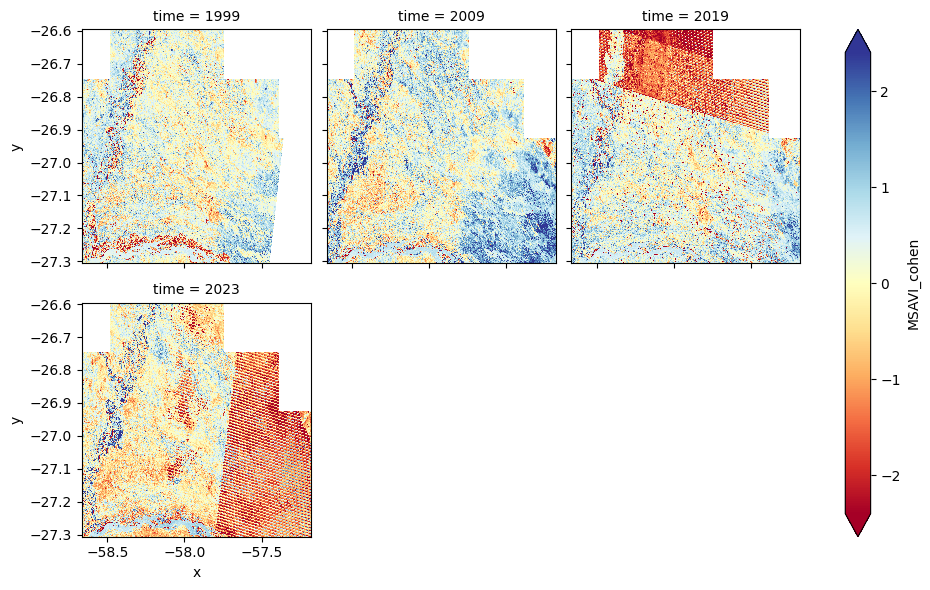

In [6]:
fi['MSAVI_cohen'].plot(col='time', col_wrap=3, cmap='RdYlBu', robust=True)

In [7]:

# 2. Montar o Google Drive
#from google.colab import drive
#drive.mount('/content/drive')


# Define the chunk size (adjust as needed)
chunks = {'time': 1, 'y': 500, 'x': 500}

# Define the path to your dataset
dataset_path = '/content/drive/MyDrive/Vários/Pilar/Tercer articulo/Resultados/bosque_indices_ndfi.nc'  # Update with your path

# Load the dataset with Dask and convert arrays to CuPy
ds = xr.open_dataset(dataset_path, chunks=chunks)

# Convert data variables to CuPy arrays
for var in ds.data_vars:
    ds[var].data = ds[var].data.map_blocks(cp.asarray, dtype=cp.float32)

# 4. Definir a lista de variáveis a serem processadas
# Define the list of variables to process
variables_to_process = ['NDFI']
# Define the reference year and years to compare
reference_year = '1989'
other_years = ['1999', '2009', '2019', '2023']

# Initialize the results dictionary
results = {}

for var in tqdm(variables_to_process, desc='Processando variáveis'):
    if var in ds:
        # Get reference data and ensure it's a CuPy array
        ref_data = ds[var].sel(time=reference_year).squeeze('time').data

        # Initialize lists to store results for each year
        cohen_list = []
        perc_change_list = []
        drnorm_list = []

        for year in tqdm(other_years, desc=f'Processando {var}', leave=False):
            # Get current data
            curr_data = ds[var].sel(time=year).squeeze('time').data

            # 6a. Calculate the difference between the current year and the reference
            diff = curr_data - ref_data

            # 6b. Calculate the standard deviation over spatial dimensions
            std_ref = da.nanstd(ref_data, axis=(0, 1))
            std_curr = da.nanstd(curr_data, axis=(0, 1))
            pooled_std = da.sqrt((std_ref**2 + std_curr**2) / 2)

            # 6c. Calculate Cohen's d
            cohen_d = diff / pooled_std
            cohen_d = da.where(da.isfinite(cohen_d), cohen_d, np.nan)

            # 6d. Calculate the percentage change (100 indicates no change)
            perc_change = ((curr_data - ref_data) / da.fabs(ref_data)) * 100 + 100
            #perc_change = ((curr_data) / da.fabs(ref_data)) * 100 + 100
            perc_change = da.where(da.isfinite(perc_change), perc_change, np.nan)

            # 6e. Calculate the normalized relative difference
            drnorm = (curr_data - ref_data) / (curr_data + ref_data)
            drnorm = da.where(da.isfinite(drnorm), drnorm, np.nan)

            # Create DataArrays
            cohen_da = xr.DataArray(cohen_d, dims=['y', 'x'], coords={'y': ds['y'], 'x': ds['x']})
            cohen_da = cohen_da.expand_dims('time').assign_coords(time=[year])

            perc_change_da = xr.DataArray(perc_change, dims=['y', 'x'], coords={'y': ds['y'], 'x': ds['x']})
            perc_change_da = perc_change_da.expand_dims('time').assign_coords(time=[year])

            drnorm_da = xr.DataArray(drnorm, dims=['y', 'x'], coords={'y': ds['y'], 'x': ds['x']})
            drnorm_da = drnorm_da.expand_dims('time').assign_coords(time=[year])

            # Append to lists
            cohen_list.append(cohen_da)
            perc_change_list.append(perc_change_da)
            drnorm_list.append(drnorm_da)

        # Concatenate results along 'time' dimension
        cohen_da = xr.concat(cohen_list, dim='time')
        perc_change_da = xr.concat(perc_change_list, dim='time')
        drnorm_da = xr.concat(drnorm_list, dim='time')

        # Assign names
        cohen_da.name = f'{var}_cohen'
        perc_change_da.name = f'{var}_perc'
        drnorm_da.name = f'{var}_drnorm'
        # Add to results
        results[f'{var}_cohen'] = cohen_da
        results[f'{var}_perc'] = perc_change_da
        results[f'{var}_drnorm'] = drnorm_da

# Create the results Dataset
results_ds = xr.Dataset(results)

# Transpose dimensions to (time, y, x)
results_ds = results_ds.transpose('time', 'y', 'x')

# Compute the results
results_ds = results_ds.compute()

# Converter arrays do CuPy para arrays do NumPy
for var in results_ds.data_vars:
    data = results_ds[var].data
    if isinstance(data, cp.ndarray):
        # Converter o array do CuPy para um array do NumPy
        results_ds[var].data = cp.asnumpy(data)

# 9. Salvar o resultado no Google Drive
output_path = '/content/drive/MyDrive/Vários/Pilar/Tercer articulo/Resultados/bosque_indices_ndfi_diferencas.nc'

# Salvar o dataset
results_ds.to_netcdf(output_path)
print(f"Resultados salvos em: {output_path}")

INFO:distributed.core:Event loop was unresponsive in Nanny for 13.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 13.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 13.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 13.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 13.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause ti

Processando variáveis:   0%|          | 0/1 [00:00<?, ?it/s]

Processando NDFI:   0%|          | 0/4 [00:00<?, ?it/s]

Resultados salvos em: /content/drive/MyDrive/Vários/Pilar/Tercer articulo/Resultados/bosque_indices_ndfi_diferencas.nc
